In [15]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.preprocessing import QuantileTransformer

In [16]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  

In [17]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions, calculate_shift_value


In [18]:
################################# 数据 读取-处理 开始#################################
sheet = pd.read_excel('data_input/美国10债Non-trend.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
# 把date 变成 index 
sheet = sheet.set_index('Date')
# 寻找 预测值的 最新日期 
last_day = sheet['10年期美国国债收益率Non-Trend/F0.05拟合残差/美国经济惊喜指数'].last_valid_index()


future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=30, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

# 确保索引按时间排序
sheet = sheet.sort_index()

In [19]:
sheet.columns

Index(['10年期美国国债收益率Non-Trend/F0.05拟合残差/美国经济惊喜指数', '费城半导体指数22日环比',
       '美国首次申领失业金人数/4WMA', '密歇根大学消费者信心指数', '美国零售汽油价格4周环比', '美国经济惊喜指数',
       '10年期美国国债收益率Non-Trend/F0.05', 'WTI原油期货价格', '美国新增非农就业人数',
       '美国经济政策不确定性指数/7DMA'],
      dtype='object')

In [20]:
sheet

,10年期美国国债收益率Non-Trend/F0.05拟合残差/美国经济惊喜指数,费城半导体指数22日环比,美国首次申领失业金人数/4WMA,密歇根大学消费者信心指数,美国零售汽油价格4周环比,美国经济惊喜指数,10年期美国国债收益率Non-Trend/F0.05,WTI原油期货价格,美国新增非农就业人数,美国经济政策不确定性指数/7DMA
1985-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103.8300
1985-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,200.1300
1985-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,152.1067
1985-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,143.6925
1985-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,132.6660
...,...,...,...,...,...,...,...,...,...,...
2025-08-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-08-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
################################# 处理缺失值 #################################
'''
1. 因子进行填充
2. 用 Dtool 的 fill_missing_values 填充因子
'''
fill_methods = {
'费城半导体指数22日环比':'interpolate',
'美国首次申领失业金人数/4WMA':'interpolate', 
'密歇根大学消费者信心指数':'interpolate', 
'美国零售汽油价格4周环比':'interpolate', 
'美国经济惊喜指数':'interpolate', 
'WTI原油期货价格':'interpolate', 
'美国新增非农就业人数':'interpolate',
'美国经济政策不确定性指数/7DMA':'interpolate'
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
#################################  因子处理  #################################
# 领先性

sheet['密歇根大学消费者信心指数_提前30天'] = sheet['密歇根大学消费者信心指数'].shift(30)
sheet['费城半导体指数22日环比_提前20天'] = sheet['费城半导体指数22日环比'].shift(80)
sheet['美国零售汽油价格4周环比_提前30天'] = sheet['美国零售汽油价格4周环比'].shift(30)
sheet['美国首次申领失业金人数/4WMA_提前30天'] = sheet['美国首次申领失业金人数/4WMA'].shift(30)
sheet['美国经济惊喜指数_提前56天'] = sheet['美国经济惊喜指数'].shift(60)
sheet['WTI原油期货价格_提前20天'] = sheet['WTI原油期货价格'].shift(20)
sheet['美国新增非农就业人数_提前30天'] = sheet['美国新增非农就业人数'].shift(30)
sheet['美国经济政策不确定性指数/7DMA_提前20天'] = sheet['美国经济政策不确定性指数/7DMA'].shift(20)


# 逆序
sheet['美国首次申领失业金人数/4WMA_提前30天_逆序'] = reverse_column(sheet, '美国首次申领失业金人数/4WMA_提前30天')
sheet['美国经济政策不确定性指数/7DMA_提前20天_逆序'] = reverse_column(sheet, '美国经济政策不确定性指数/7DMA_提前20天')
# 截取部分数据 
sheet['美国首次申领失业金人数/4WMA_提前30天_逆序_2024-03-01'] = np.where(
    sheet.index >= pd.Timestamp('2024-03-01'),
    sheet['美国首次申领失业金人数/4WMA_提前30天_逆序'],
    np.nan
)

'''
# 以下代码属于因子工程部分，根据分布情况进行非线性变换
# 示例1：如果“全国观影人次/30DMA_提前25天”呈现严重右偏分布，则可以采用对数转换，将其数值差异放大
sheet['美国经济惊喜指数_提前56天_log'] = np.log1p(sheet['美国经济惊喜指数_提前56天'])

# 示例2：如果发现“中国服务业PMI/3MMA_提前30天”可以用平方转换来更好地表达数据特征，则可使用如下方法：
sheet['美国经济惊喜指数_提前56天_power'] = sheet['美国经济惊喜指数_提前56天'] ** 2

# 示例1：如果“全国观影人次/30DMA_提前25天”呈现严重右偏分布，则可以采用对数转换，将其数值差异放大
sheet['全国观影人次/30DMA_提前25天'] = np.log1p(sheet['全国观影人次/30DMA_提前25天'])

# 示例2：如果发现“中国服务业PMI/3MMA_提前30天”可以用平方转换来更好地表达数据特征，则可使用如下方法：
sheet['中国服务业PMI/3MMA_提前30天'] = sheet['中国服务业PMI/3MMA_提前30天'] ** 2
# np.sqrt(x) 计算 x 的平方根，适用于轻度右偏分布的数据
sheet['全国观影人次/30DMA_提前25天'] = np.sqrt(sheet['全国观影人次/30DMA_提前25天'])
# 1 / x 计算倒数，适用于有较大值的右偏数据
sheet['全国观影人次/30DMA_提前25天'] = 1 / sheet['全国观影人次/30DMA_提前25天']
# 对数据应用Box-Cox变换，确保数据为正数后进行变换
sheet['全国观影人次/30DMA_提前25天'] = sheet['全国观影人次/30DMA_提前25天'].apply(lambda x: max(x, 1e-5))  # 确保数据为正
sheet['全国观影人次/30DMA_提前25天'], _ = stats.boxcox(sheet['全国观影人次/30DMA_提前25天'])
# 备注: 适用于右偏分布数据，目标是将数据转换为更接近正态分布。
# np.exp(x) 对数据应用指数变换，适用于左偏分布数据
sheet['全国观影人次/30DMA_提前25天'] = np.exp(sheety['全国观影人次/30DMA_提前25天'])
# 备注: 适用于左偏数据或当数据呈现指数增长趋势时
# 对数据进行平方变换，适用于特征和目标之间有非线性关系的情况
sheet['全国观影人次/30DMA_提前25天'] = sheet['全国观影人次/30DMA_提前25天']**2  # 对数据进行平方变换
# 备注: 用于处理非线性关系，适合与目标变量之间有二次关系的数据。
# 将数据转换为标准正态分布或均匀分布
qt = QuantileTransformer(output_distribution='normal')  # 或 'uniform'
sheet['全国观影人次/30DMA_提前25天'] = qt.fit_transform(sheet[['全国观影人次/30DMA_提前25天']])
# 备注: 适用于非正态分布的特征，通过转换使数据服从标准正态分布或均匀分布。

'''
################################# 数据筛选  #################################
# 重置索引 确保 `Date` 为 datetime 类型
sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])
# 筛选日期大于 2024-01-01 的行
sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-01-01')]
# 重置索引,使其从0开始 
sheet_daily = sheet_daily.reset_index(drop=True)
# 删除 在 last_day 之前 预测标的 为 空值的 行
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['10年期美国国债收益率Non-Trend/F0.05拟合残差/美国经济惊喜指数'].notna())
]

################################# 数据 读取-处理 结束 #################################

In [22]:
sheet_daily

,Date,10年期美国国债收益率Non-Trend/F0.05拟合残差/美国经济惊喜指数,10年期美国国债收益率Non-Trend/F0.05,费城半导体指数22日环比,美国首次申领失业金人数/4WMA,密歇根大学消费者信心指数,美国零售汽油价格4周环比,美国经济惊喜指数,WTI原油期货价格,美国新增非农就业人数,...,费城半导体指数22日环比_提前20天,美国零售汽油价格4周环比_提前30天,美国首次申领失业金人数/4WMA_提前30天,美国经济惊喜指数_提前56天,WTI原油期货价格_提前20天,美国新增非农就业人数_提前30天,美国经济政策不确定性指数/7DMA_提前20天,美国首次申领失业金人数/4WMA_提前30天_逆序,美国经济政策不确定性指数/7DMA_提前20天_逆序,美国首次申领失业金人数/4WMA_提前30天_逆序_2024-03-01
2,2023-01-03,0.1472,0.2746,-0.1153,207.464286,60.293548,-0.018943,-1.3,77.21,251.451613,...,-0.154567,-0.112543,212.00,18.900000,77.420000,257.838710,127.5900,5274.00,594.8757,NaN
3,2023-01-04,0.0444,0.1710,-0.0839,207.392857,60.458065,-0.011329,-0.5,73.22,260.935484,...,-0.143533,-0.117014,212.00,19.766667,76.370000,256.548387,132.3243,5274.00,590.1414,NaN
4,2023-01-05,0.1252,0.1874,-0.0912,207.321429,60.622581,-0.003714,9.1,73.93,270.419355,...,-0.132500,-0.121486,212.00,20.633333,74.500000,255.258065,130.1471,5274.00,592.3186,NaN
5,2023-01-06,-0.0051,0.0238,-0.0372,207.250000,60.787097,0.003900,-7.3,73.73,279.903226,...,-0.133500,-0.125957,212.00,21.500000,74.953333,253.967742,133.5414,5274.00,588.9243,NaN
8,2023-01-09,-0.0248,0.0002,0.0049,206.178571,61.280645,0.026357,-9.1,74.87,308.354839,...,-0.070900,-0.135714,211.75,13.200000,76.020000,250.096774,97.5586,5274.25,624.9071,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
960,2025-08-28,NaN,NaN,0.0818,224.500000,61.800000,-0.027600,2.4,66.16,147.000000,...,0.133800,-0.027600,224.50,-23.300000,66.160000,147.000000,375.6914,5261.50,346.7743,5261.5
961,2025-08-29,NaN,NaN,0.0818,224.500000,61.800000,-0.027600,2.4,66.16,147.000000,...,0.136700,-0.027600,224.50,-23.900000,66.160000,147.000000,375.6914,5261.50,346.7743,5261.5
962,2025-09-01,NaN,NaN,0.0818,224.500000,61.800000,-0.027600,2.4,66.16,147.000000,...,0.139600,-0.027600,224.50,-22.866667,66.160000,147.000000,375.6914,5261.50,346.7743,5261.5
963,2025-09-02,NaN,NaN,0.0818,224.500000,61.800000,-0.027600,2.4,66.16,147.000000,...,0.142500,-0.027600,224.50,-21.833333,66.160000,147.000000,375.6914,5261.50,346.7743,5261.5


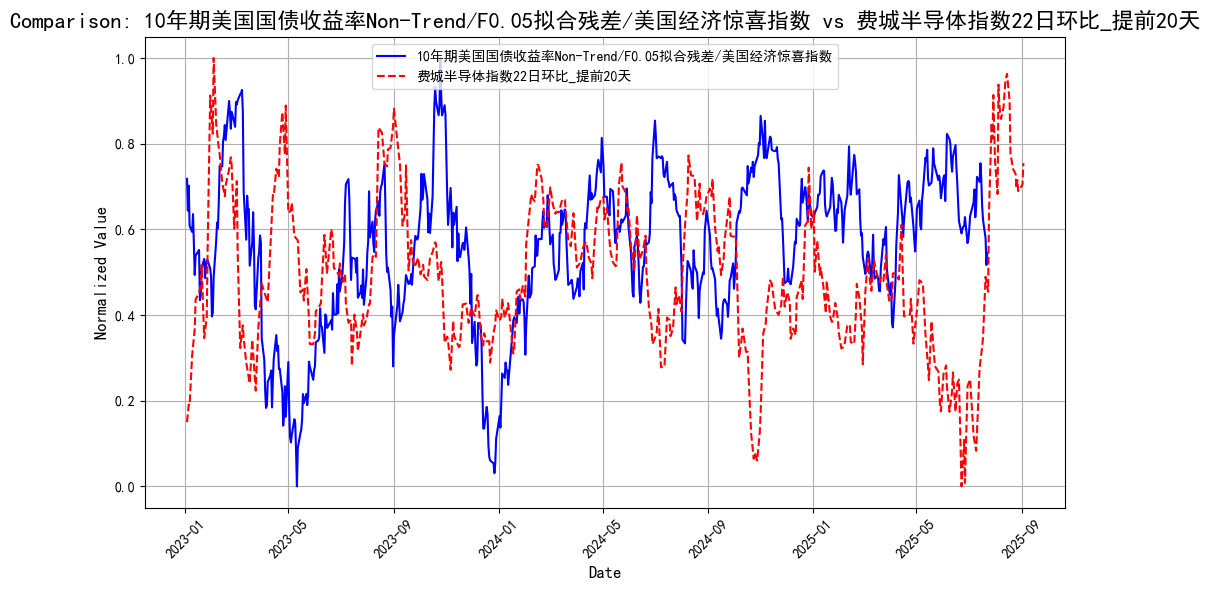

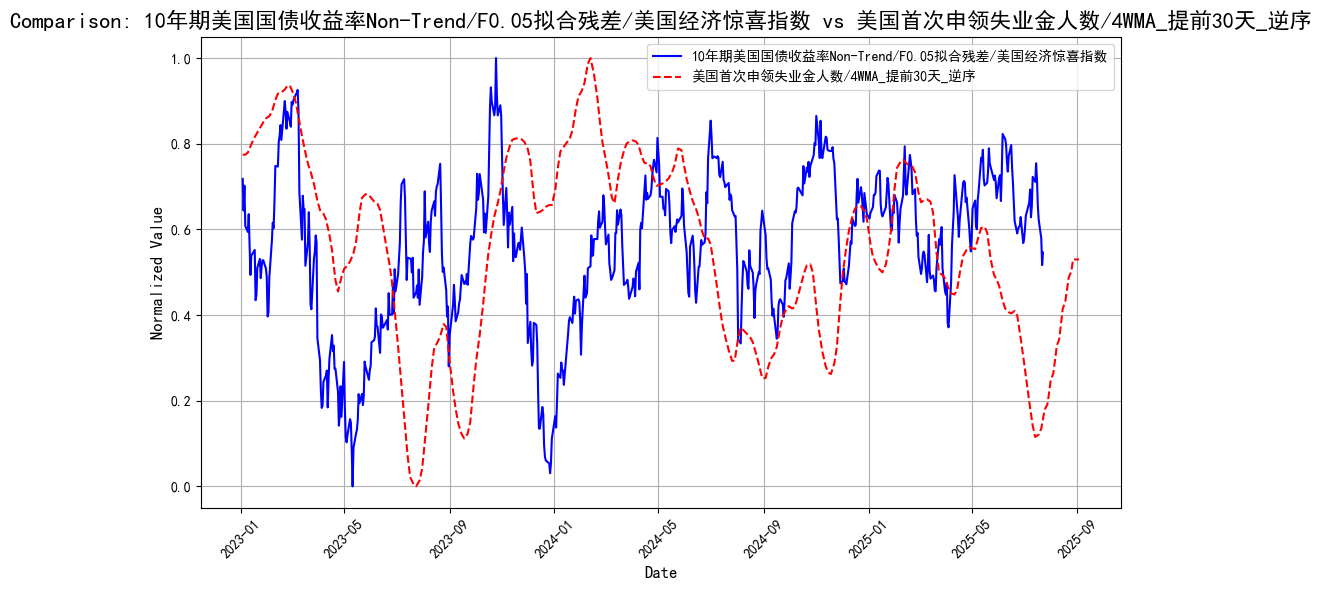

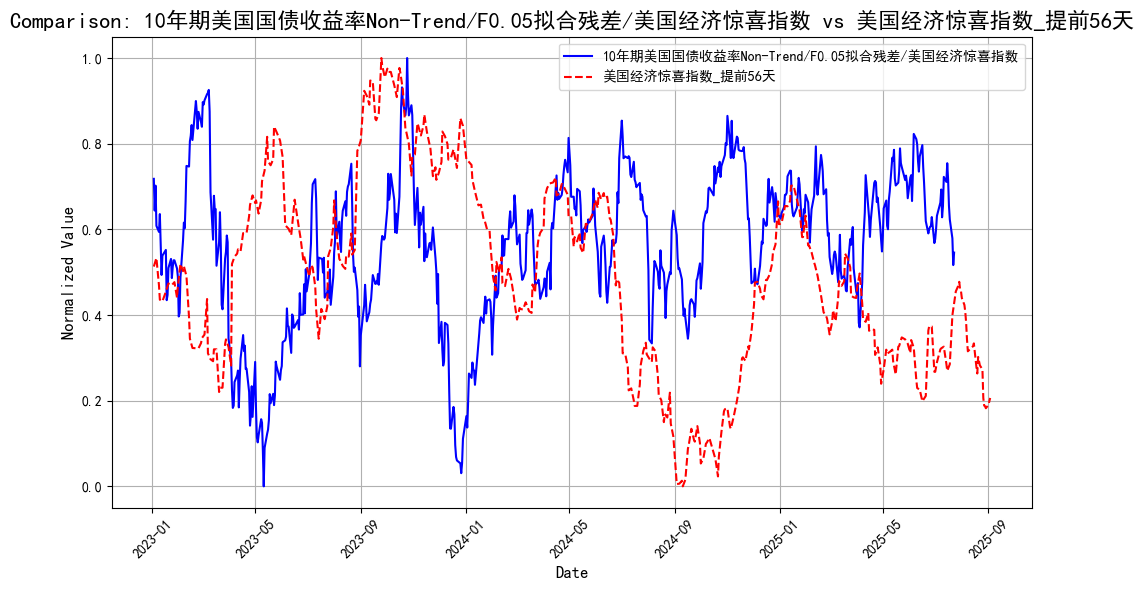

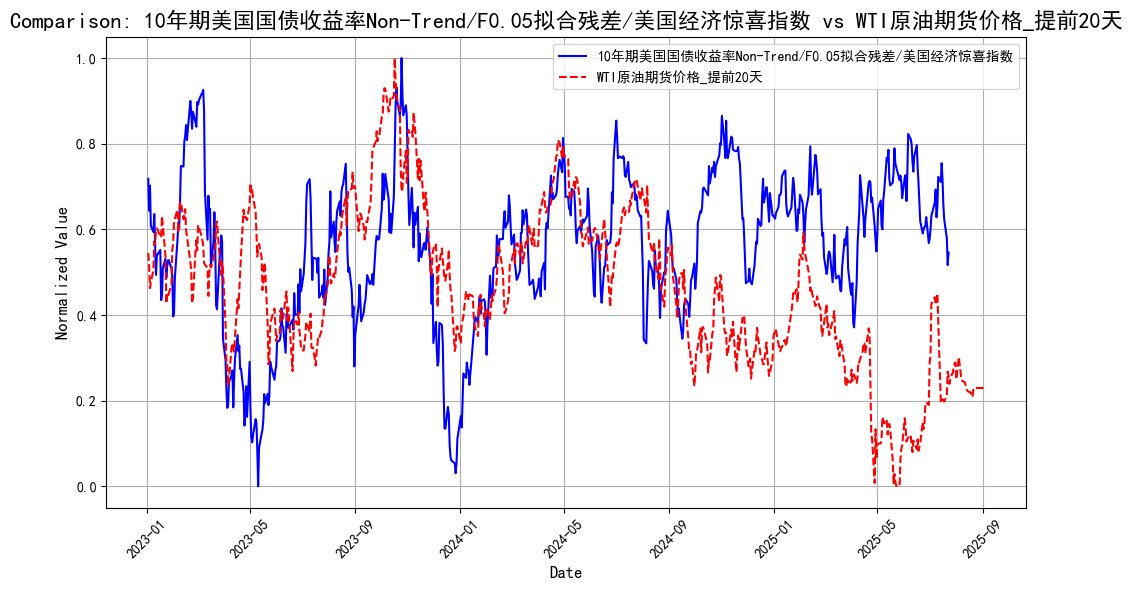

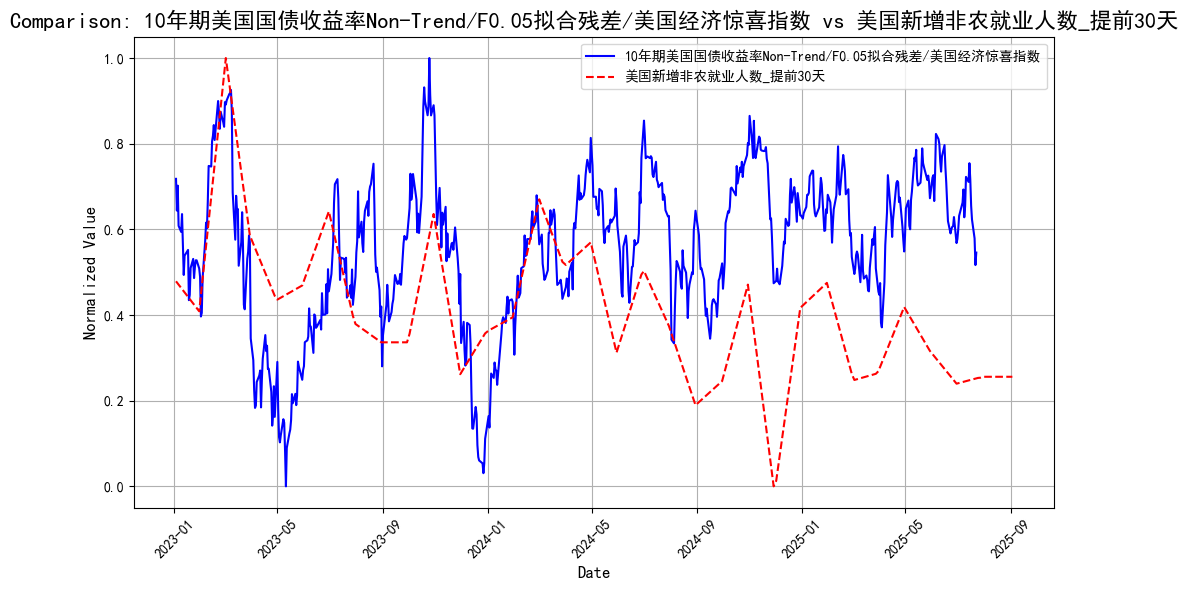

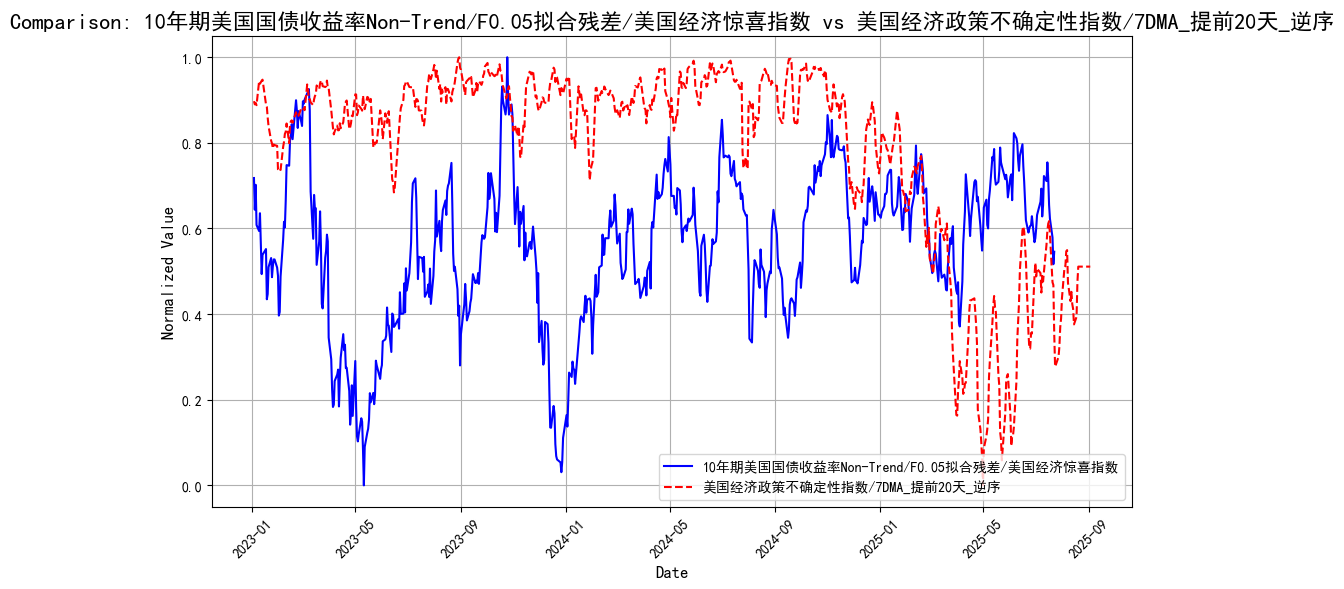

In [23]:
################################# X 和 Y 对比 观察领先性 #################################
data_filtered_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    data_filtered_plot, 
    main_col='10年期美国国债收益率Non-Trend/F0.05拟合残差/美国经济惊喜指数', 
    compare_cols=[
    '费城半导体指数22日环比_提前20天',
    '美国首次申领失业金人数/4WMA_提前30天_逆序',
    #'密歇根大学消费者信心指数_提前30天', 
    #'美国零售汽油价格4周环比_提前30天', 
    '美国经济惊喜指数_提前56天',
    'WTI原油期货价格_提前20天',
    '美国新增非农就业人数_提前30天',
    '美国经济政策不确定性指数/7DMA_提前20天_逆序'
       ]
)

In [24]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 20
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

# 因子集
feature_columns = [
    '费城半导体指数22日环比_提前20天',
    '美国首次申领失业金人数/4WMA_提前30天_逆序',
    #'密歇根大学消费者信心指数_提前30天', 
    #'美国零售汽油价格4周环比_提前30天', 
    '美国经济惊喜指数_提前56天',
    'WTI原油期货价格_提前20天',
    '美国新增非农就业人数_提前30天',
    '美国经济政策不确定性指数/7DMA_提前20天_逆序'
]
# 预测目标column
predict_column = '10年期美国国债收益率Non-Trend/F0.05拟合残差/美国经济惊喜指数'

# 准备训练、测试和未来数据的输入和输出
X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

'''
######################################## 因子权重调节 #################################
feature_weights_dict = {
    '全国观影人次/30DMA_提前25天': 100.0,
    # 如有其他因子需要特殊权重，可继续添加，例如:
    # '传统汽车销量12月移动平均同比_提前80天': 1.5,
}

# 初始化所有因子的权重为1（与 feature_columns 顺序一致）
feature_weights = np.ones(len(feature_columns))

# 根据字典更新指定因子的权重
for feature, weight in feature_weights_dict.items():
    if feature in feature_columns:
        idx = feature_columns.index(feature)
        feature_weights[idx] = weight

# 打印每个因子的权重，便于检查
for feature, weight in zip(feature_columns, feature_weights):
    print(f"{feature}: {weight}")

# 将权重应用到原始数据上（所有数据均乘以对应的权重）
for idx, feature in enumerate(feature_columns):
    weight = feature_weights[idx]
    X_train[feature] = X_train[feature] * weight
    X_test[feature] = X_test[feature] * weight
    X_future[feature] = X_future[feature] * weight
########################################################################################################################


######################################## 指定哪些因子 不需要 因子标准化 #################################

# 定义不进行标准化的因子列表（这里以‘全国观影人次/30DMA_提前25天’为例，可根据需要添加其他因子）
non_scaled_features = ['全国观影人次/30DMA_提前25天']

# 得到需要标准化的特征列表
scaled_features = [col for col in feature_columns if col not in non_scaled_features]

# 分别提取需要标准化的部分数据
X_train_to_scale = X_train[scaled_features]
X_test_to_scale = X_test[scaled_features]
X_future_to_scale = X_future[scaled_features]

# 初始化 StandardScaler 并对待标准化特征进行拟合和转换
scaler = StandardScaler()
X_train_scaled_part = scaler.fit_transform(X_train_to_scale)
X_test_scaled_part = scaler.transform(X_test_to_scale)
X_future_scaled_part = scaler.transform(X_future_to_scale)

# 将转换后的数据合并回原始 DataFrame，保证未标准化的因子保持原始数据
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_future_scaled = X_future.copy()

X_train_scaled.loc[:, scaled_features] = X_train_scaled_part
X_test_scaled.loc[:, scaled_features] = X_test_scaled_part
X_future_scaled.loc[:, scaled_features] = X_future_scaled_part
########################################################################################################################
'''

################################# Xgboost 模型 训练 测试 预测 #################################

# 正则化所有input 选择standard 因为金融数据 会超过过往极值的问题
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

# 创建DMatrix对象,设置样本权重以降低异常值的影响
train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数

params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.09,  # 较小的学习率
    'max_depth': 5,  # 控制树的深度防止过拟合
    'min_child_weight': 2,  # 控制过拟合
    'subsample': 0.9,  # 随机采样防止过拟合
    'colsample_bytree': 0.9,  # 特征随机采样
    'gamma': 0,  # 控制分裂
    'reg_alpha': 0.5,  # L1正则化
    'reg_lambda': 1,  # L2正则化
    'eval_metric': 'rmse', # 评估指标：选择“rmse”
    'seed': 42, # 随机种子
}

# 训练模型，使用早停策略，最大训练轮数
num_boost_round = 1000
# 记录评估指标、存储
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=100 # 每100轮输出一次评估信息
)

# 训练集预测
y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
# 测试集预测
y_test_pred_dmatrix = model.predict(test_dmatrix)

# 计算 MSE 和 R² 分数
# 计算训练集和测试集的MSE
train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
# 计算训练集和测试集的R²
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
# 打印结果
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
# 测试预测 存储
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
# 未来预测 存储
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:0.12605	train-rmse:0.22807


[100]	eval-rmse:0.10141	train-rmse:0.05583
[200]	eval-rmse:0.10144	train-rmse:0.04383
[300]	eval-rmse:0.10106	train-rmse:0.04062
[400]	eval-rmse:0.10112	train-rmse:0.03899
[500]	eval-rmse:0.10177	train-rmse:0.03779
[600]	eval-rmse:0.10189	train-rmse:0.03691
[700]	eval-rmse:0.10197	train-rmse:0.03593
[800]	eval-rmse:0.10188	train-rmse:0.03541
[900]	eval-rmse:0.10178	train-rmse:0.03495
[999]	eval-rmse:0.10191	train-rmse:0.03456
训练集 MSE (DMatrix): 0.0012, 训练集 R² (DMatrix): 0.9806
测试集 MSE (DMatrix): 0.0104, 测试集 R² (DMatrix): -0.4341


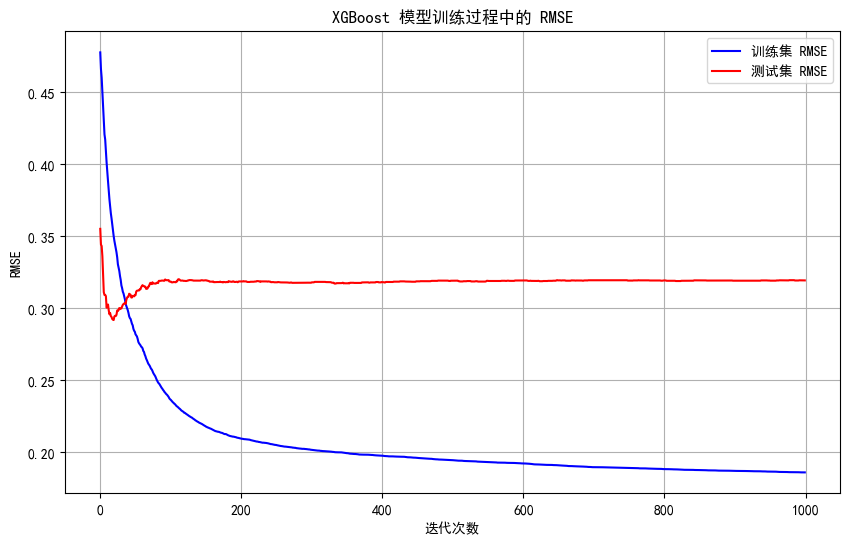

In [25]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################

# 确保数据拼接后索引是连续的，防止数据对不齐
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

# 对所有数据进行标准化（使用之前拟合的 scaler）
X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重


# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=100
)

# 对全部数据进行预测（X_train + X_test）
y_all_pred = model_all.predict(all_data_dmatrix)

# 对未来数据进行预测
y_future_pred_all = model_all.predict(future_dmatrix_all)

# 计算全部数据的 MSE 和 R² 分数
all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

# 打印结果
print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred

# 存储未来预测结果
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:0.22536


[100]	train-rmse:0.05461
[200]	train-rmse:0.04447
[300]	train-rmse:0.04081
[400]	train-rmse:0.03918
[500]	train-rmse:0.03791
[600]	train-rmse:0.03692
[700]	train-rmse:0.03607
[800]	train-rmse:0.03544
[900]	train-rmse:0.03496
[999]	train-rmse:0.03455
全部数据 MSE: 0.0012, 全部数据 R²: 0.9802


In [27]:
'''
################################# 可视化 #################################
'''
# 蓝色：真实数据
# 绿色：训练集数据 预测 模型表现
# 紫色：测试集数据 预测 模型表现
# 红线：未来集数据 预测 正常预测 
# 黑线：未来集数据 预测 全部数据训练预测 
'''
# 创建一个新的图形
plt.figure(figsize=(30, 8))

# 训练集和测试集的连接点(预测值)
train_last_date = train_data['Date'].iloc[-1]
test_first_date = test_data['Date'].iloc[0]
train_last_value = y_train_pred_dmatrix[-1]
test_first_value = y_test_pred_dmatrix[0]

# 训练集和测试集的连接点(真实值)
train_last_date_real = train_data['Date'].iloc[-1]
test_first_date_real = test_data['Date'].iloc[0]
train_last_value_real = y_train.iloc[-1]
test_first_value_real = y_test.iloc[0]

# 测试集和未来集的连接点(普通预测)
test_last_date = test_data['Date'].iloc[-1]
future_first_date = future_data['Date'].iloc[0]
test_last_value = y_test_pred_dmatrix[-1]
future_first_value = future_data['预测值'].iloc[0]

# 测试集和未来集的连接点(全量预测)
test_last_date_all = test_data['Date'].iloc[-1]
future_first_date_all = future_data['Date'].iloc[0]
test_last_value_all = y_test.iloc[-1]
future_first_value_all = future_data['预测值_全量'].iloc[0]

# 绘制主要数据
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加连接线
plt.plot([train_last_date, test_first_date], [train_last_value, test_first_value], color='purple')
plt.plot([test_last_date, future_first_date], [test_last_value, future_first_value], color='red')
plt.plot([train_last_date_real, test_first_date_real], [train_last_value_real, test_first_value_real], color='blue')
plt.plot([test_last_date_all, future_first_date_all], [test_last_value_all, future_first_value_all], color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('10年期美国国债收益率Non-Trend/F0.05拟合残差/美国经济惊喜指数')
plt.legend()
plt.grid(True)
plt.show()
'''

"\n# 创建一个新的图形\nplt.figure(figsize=(30, 8))\n\n# 训练集和测试集的连接点(预测值)\ntrain_last_date = train_data['Date'].iloc[-1]\ntest_first_date = test_data['Date'].iloc[0]\ntrain_last_value = y_train_pred_dmatrix[-1]\ntest_first_value = y_test_pred_dmatrix[0]\n\n# 训练集和测试集的连接点(真实值)\ntrain_last_date_real = train_data['Date'].iloc[-1]\ntest_first_date_real = test_data['Date'].iloc[0]\ntrain_last_value_real = y_train.iloc[-1]\ntest_first_value_real = y_test.iloc[0]\n\n# 测试集和未来集的连接点(普通预测)\ntest_last_date = test_data['Date'].iloc[-1]\nfuture_first_date = future_data['Date'].iloc[0]\ntest_last_value = y_test_pred_dmatrix[-1]\nfuture_first_value = future_data['预测值'].iloc[0]\n\n# 测试集和未来集的连接点(全量预测)\ntest_last_date_all = test_data['Date'].iloc[-1]\nfuture_first_date_all = future_data['Date'].iloc[0]\ntest_last_value_all = y_test.iloc[-1]\nfuture_first_value_all = future_data['预测值_全量'].iloc[0]\n\n# 绘制主要数据\nplt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')\nplt.plot(train_data['Date'], y_train_

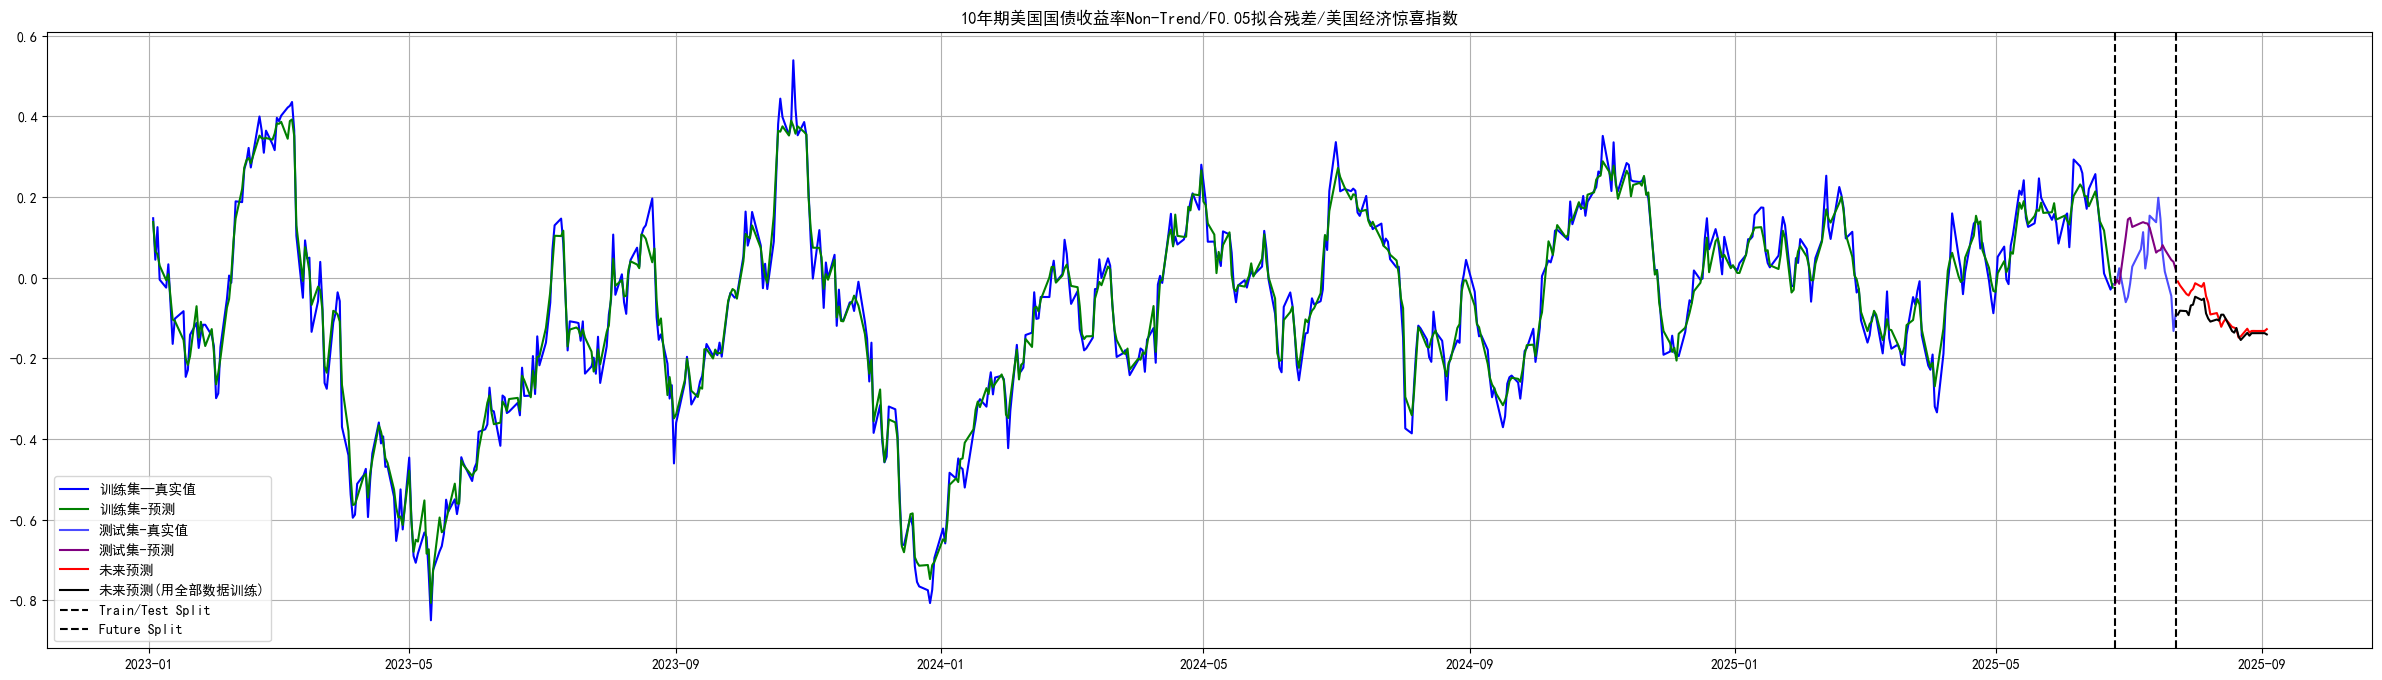

In [28]:

################################# 可视化 #################################

# 蓝色：真实数据
# 绿色：训练集数据 预测 模型表现
# 紫色：测试集数据 预测 模型表现
# 红线：未来集数据 预测 正常预测 
# 黑线：未来集数据 预测 全部数据训练预测 

# 创建一个新的图形
plt.figure(figsize=(30, 8))
future_data = plot_predictions(y_test, future_data, col=True, label=True)
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('10年期美国国债收益率Non-Trend/F0.05拟合残差/美国经济惊喜指数')
plt.legend()
plt.grid(True)
plt.show()



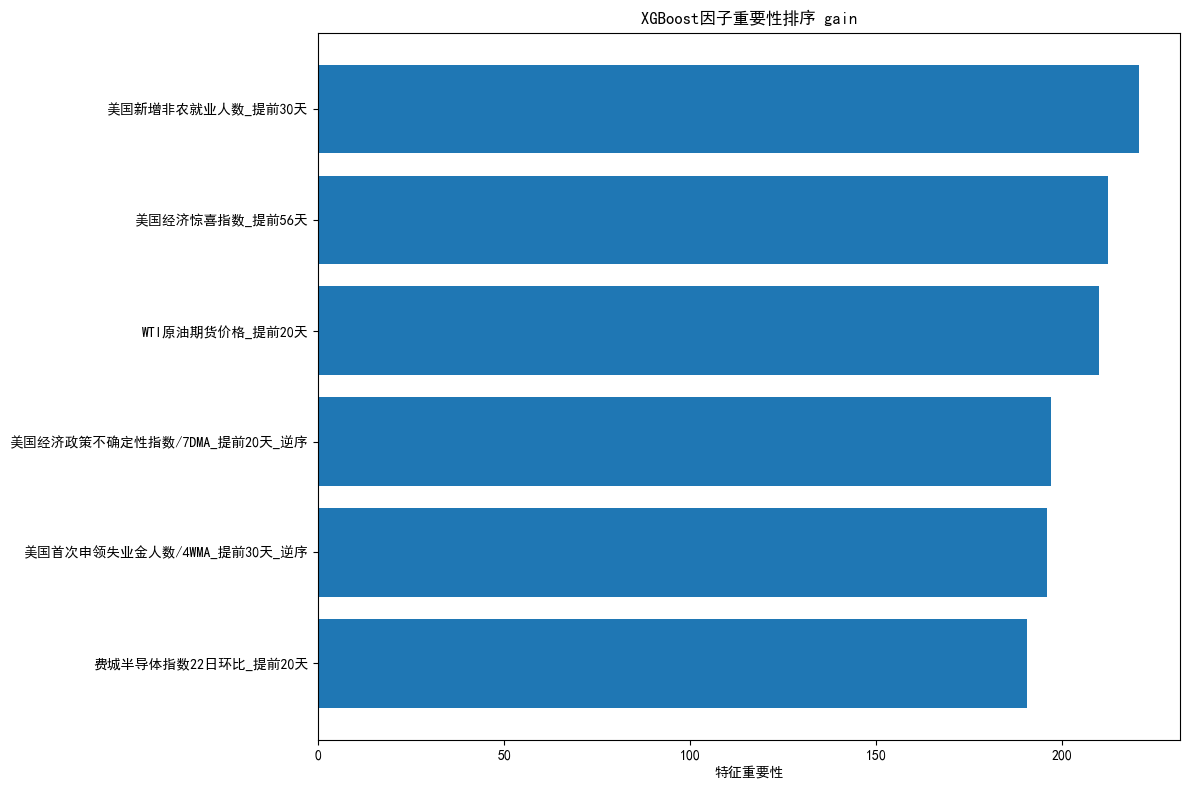

In [29]:

# 创建特征重要性排序的DataFrame
plt.figure(figsize=(12, 8))
importance_type = 'cover'
feature_importance = model_all.get_score(importance_type=importance_type)

importance_df = pd.DataFrame({
    'feature': list(feature_importance.keys()),
    'importance': list(feature_importance.values())
})

# 将特征名称从f0、f1等映射到实际的列名
feature_names = dict(zip([f'f{i}' for i in range(len(X_train.columns))], X_train.columns))
importance_df['feature_name'] = importance_df['feature'].map(feature_names)

# 按重要性降序排序
importance_df_sorted = importance_df.sort_values('importance', ascending=True)

# 绘制水平条形图
plt.barh(range(len(importance_df_sorted)), importance_df_sorted['importance'])
plt.yticks(range(len(importance_df_sorted)), importance_df_sorted['feature_name'], fontsize=10)
plt.xlabel('特征重要性')
plt.title('XGBoost因子重要性排序 gain')
plt.tight_layout()
plt.show()


---

In [30]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并历史真实值和预测值
merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
# 按日期排序 倒叙
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
# 将日期格式转换为年/月/日格式
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
# 保存成excel 在 eta 文件夹里
merged_df_daily.to_excel('eta/10年期美国国债收益率Non-Trend-F0.05拟合残差-美国经济惊喜指数_合并数据.xlsx', index=False,float_format='%.6f')
merged_df_daily 

,Date,真实值,预测值
668,2025/09/03,NaN,-0.140881
667,2025/09/02,NaN,-0.137709
666,2025/09/01,NaN,-0.137709
665,2025/08/29,NaN,-0.137709
664,2025/08/28,NaN,-0.137709
...,...,...,...
4,2023/01/09,-0.0248,NaN
3,2023/01/06,-0.0051,NaN
2,2023/01/05,0.1252,NaN
1,2023/01/04,0.0444,NaN


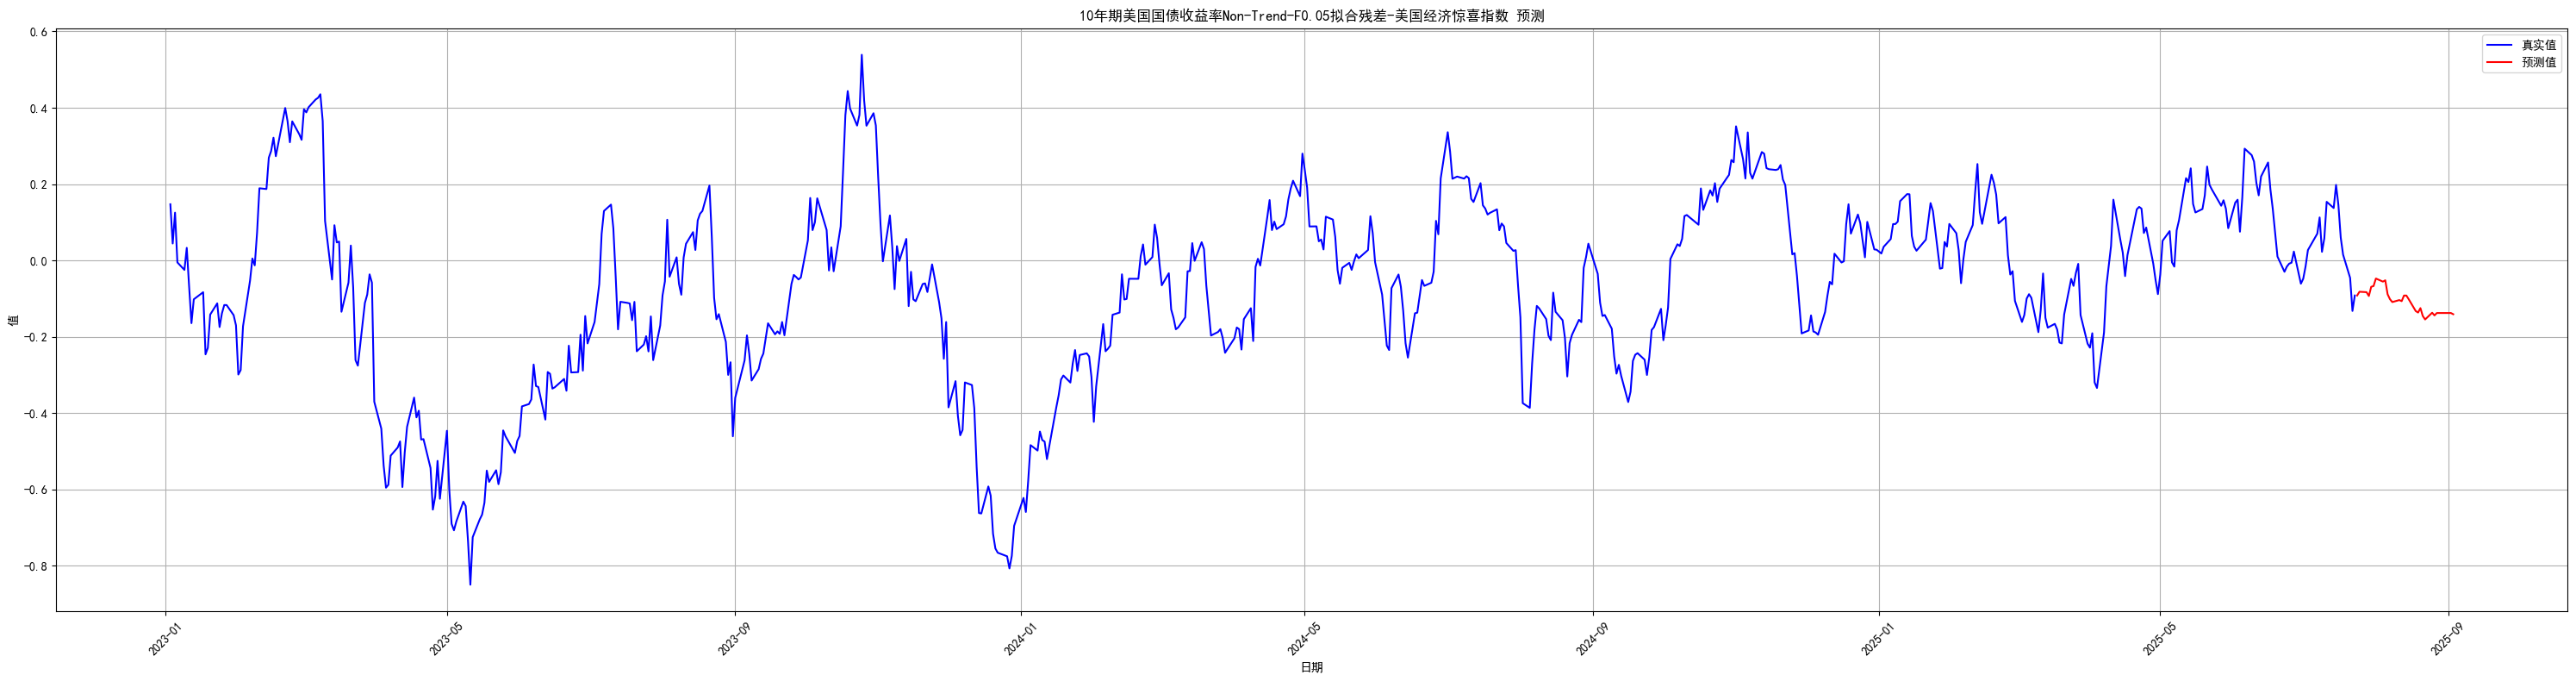

In [31]:
# 设置图形大小
plt.figure(figsize=(30, 8))
merged_df_daily_plot = merged_df_daily.copy()
# 将日期格式转换回datetime格式用于绘图
merged_df_daily_plot['Date'] = pd.to_datetime(merged_df_daily_plot['Date'])
# 绘制真实值曲线(蓝色)
plt.plot(merged_df_daily_plot['Date'], merged_df_daily_plot['真实值'], color='blue', label='真实值')
# 绘制预测值曲线(红色) 
plt.plot(merged_df_daily_plot['Date'],merged_df_daily_plot['预测值'], color='red', label='预测值')
avline_date = pd.to_datetime(last_day)
plt.legend()
plt.title('10年期美国国债收益率Non-Trend-F0.05拟合残差-美国经济惊喜指数 预测')
plt.xlabel('日期')
plt.ylabel('值')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:

############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 保存成excel
merged_df_monthly.to_excel('eta/10年期美国国债收益率Non-Trend-F0.05拟合残差-美国经济惊喜指数_月度数据.xlsx', index=False, float_format='%.4f')

In [33]:
sheet_daily.columns

Index(['Date', '10年期美国国债收益率Non-Trend/F0.05拟合残差/美国经济惊喜指数',
       '10年期美国国债收益率Non-Trend/F0.05', '费城半导体指数22日环比', '美国首次申领失业金人数/4WMA',
       '密歇根大学消费者信心指数', '美国零售汽油价格4周环比', '美国经济惊喜指数', 'WTI原油期货价格', '美国新增非农就业人数',
       '美国经济政策不确定性指数/7DMA', '密歇根大学消费者信心指数_提前30天', '费城半导体指数22日环比_提前20天',
       '美国零售汽油价格4周环比_提前30天', '美国首次申领失业金人数/4WMA_提前30天', '美国经济惊喜指数_提前56天',
       'WTI原油期货价格_提前20天', '美国新增非农就业人数_提前30天', '美国经济政策不确定性指数/7DMA_提前20天',
       '美国首次申领失业金人数/4WMA_提前30天_逆序', '美国经济政策不确定性指数/7DMA_提前20天_逆序',
       '美国首次申领失业金人数/4WMA_提前30天_逆序_2024-03-01'],
      dtype='object')

In [34]:
future_data.tail()

,Date,10年期美国国债收益率Non-Trend/F0.05拟合残差/美国经济惊喜指数,10年期美国国债收益率Non-Trend/F0.05,费城半导体指数22日环比,美国首次申领失业金人数/4WMA,密歇根大学消费者信心指数,美国零售汽油价格4周环比,美国经济惊喜指数,WTI原油期货价格,美国新增非农就业人数,...,美国首次申领失业金人数/4WMA_提前30天,美国经济惊喜指数_提前56天,WTI原油期货价格_提前20天,美国新增非农就业人数_提前30天,美国经济政策不确定性指数/7DMA_提前20天,美国首次申领失业金人数/4WMA_提前30天_逆序,美国经济政策不确定性指数/7DMA_提前20天_逆序,美国首次申领失业金人数/4WMA_提前30天_逆序_2024-03-01,预测值,预测值_全量
960,2025-08-28,NaN,NaN,0.0818,224.5,61.8,-0.0276,2.4,66.16,147.0,...,224.5,-23.300000,66.16,147.0,375.6914,5261.5,346.7743,5261.5,-0.132158,-0.137709
961,2025-08-29,NaN,NaN,0.0818,224.5,61.8,-0.0276,2.4,66.16,147.0,...,224.5,-23.900000,66.16,147.0,375.6914,5261.5,346.7743,5261.5,-0.132282,-0.137709
962,2025-09-01,NaN,NaN,0.0818,224.5,61.8,-0.0276,2.4,66.16,147.0,...,224.5,-22.866667,66.16,147.0,375.6914,5261.5,346.7743,5261.5,-0.132282,-0.137709
963,2025-09-02,NaN,NaN,0.0818,224.5,61.8,-0.0276,2.4,66.16,147.0,...,224.5,-21.833333,66.16,147.0,375.6914,5261.5,346.7743,5261.5,-0.132282,-0.137709
964,2025-09-03,NaN,NaN,0.0818,224.5,61.8,-0.0276,2.4,66.16,147.0,...,224.5,-20.800000,66.16,147.0,375.6914,5261.5,346.7743,5261.5,-0.127778,-0.140881


---

In [35]:
################################# linear regression 逆运算 #################################
'''
1. 得到 non-trend 
2. 公式： non-trend = 0.0078(美国经济惊喜指数) - 0.0474 + 残差(10年期美国国债收益率Non-Trend-F0.05拟合残差-美国经济惊喜指数)
'''
#### 日度数据 ####
# 历史真实值 non-trend 计算 和数据 (2024年 到 last-day) 
# 历史真实残差
historical_actual_nontrend = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# h获取 美国经济惊喜指数 和 残差对其
historical_actual_nontrend = historical_actual_nontrend.merge(
    sheet_daily[['Date', '美国经济惊喜指数_提前56天']], 
    on='Date', 
    how='left'
)
'''
# 历史真实值 non-trend 计算 （公式计算） (2023年 到 last-day) 
historical_actual_nontrend_daily = pd.DataFrame({
    'Date': historical_actual_nontrend[historical_actual_nontrend['Date'].dt.year >= 2023]['Date'],
    'Non-trend': 0.0078 * historical_actual_nontrend[historical_actual_nontrend['Date'].dt.year >= 2023]['美国经济惊喜指数_提前56天'] - 0.0452
                         + historical_actual_nontrend[historical_actual_nontrend['Date'].dt.year >= 2023]['真实值']
})
'''
historical_actual_nontrend_daily =  sheet_daily[['Date','10年期美国国债收益率Non-Trend/F0.05']]
historical_actual_nontrend_daily = historical_actual_nontrend_daily[historical_actual_nontrend_daily['Date'] <= last_day]
historical_actual_nontrend_daily = historical_actual_nontrend_daily.rename(columns={'10年期美国国债收益率Non-Trend/F0.05': 'Non-trend'})




# 未来预测值 non-trend 计算（预测 last-day 之后）
future_pred_nontrend_daily = pd.DataFrame({
    'Date': future_data['Date'],
#    'Non-trend': 0.0078 * future_data['美国经济惊喜指数_提前56天'] - 0.0474 + future_data['预测值_全量_移动'] 
    'Non-trend': 0.0074 * future_data['美国经济惊喜指数_提前56天']  -0.0381 + future_data['预测值_全量'] -0.05
})

# 合并历史真实值和预测值
merged_df_nontrend_daily = pd.merge(historical_actual_nontrend_daily, future_pred_nontrend_daily, on='Date', how='outer')
# 按日期排序 倒叙
merged_df_nontrend_daily = merged_df_nontrend_daily.sort_values('Date', ascending=False)
# 将日期格式转换为年/月/日格式
merged_df_nontrend_daily['Date'] = merged_df_nontrend_daily['Date'].dt.strftime('%Y/%m/%d')
# 改名字
merged_df_nontrend_daily = merged_df_nontrend_daily.rename(columns={
    'Non-trend_x': '真实值',
    'Non-trend_y': '预测值'
})
# 保存成excel 在 eta 文件夹里
merged_df_nontrend_daily.to_excel('eta/10年期美国国债收益率Non-Trend-F0.05_合并数据.xlsx', index=False,float_format='%.15f')

merged_df_nontrend_daily  

,Date,真实值,预测值
668,2025/09/03,NaN,-0.382901
667,2025/09/02,NaN,-0.387375
666,2025/09/01,NaN,-0.395022
665,2025/08/29,NaN,-0.402669
664,2025/08/28,NaN,-0.398229
...,...,...,...
4,2023/01/09,0.0002,NaN
3,2023/01/06,0.0238,NaN
2,2023/01/05,0.1874,NaN
1,2023/01/04,0.1710,NaN


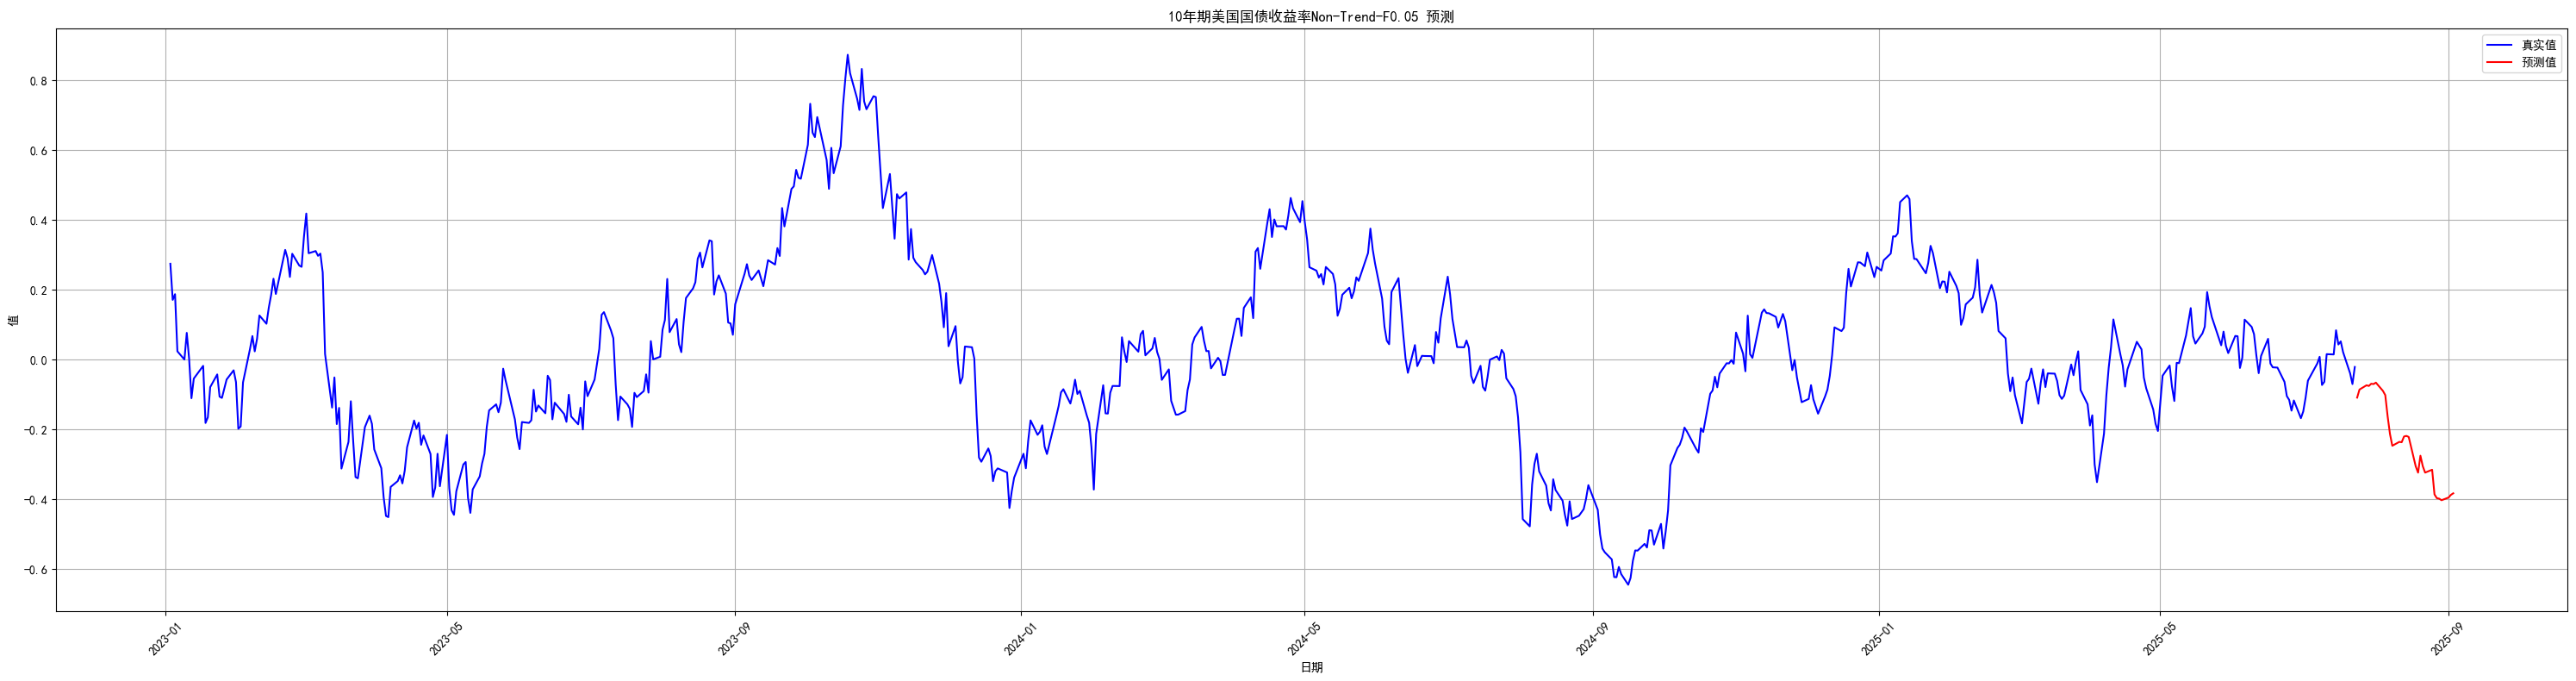

In [36]:
# 设置图形大小
plt.figure(figsize=(30, 8))

merged_df_nontrend_daily_plot = merged_df_nontrend_daily
# 将日期格式转换回datetime格式用于绘图
merged_df_nontrend_daily_plot['Date'] = pd.to_datetime(merged_df_nontrend_daily_plot['Date'])

# 绘制真实值曲线(蓝色)
plt.plot(merged_df_nontrend_daily_plot['Date'], merged_df_nontrend_daily_plot['真实值'], color='blue', label='真实值')

# 绘制预测值曲线(红色) 
plt.plot(merged_df_nontrend_daily_plot['Date'], merged_df_nontrend_daily_plot['预测值'], color='red', label='预测值')


avline_date = pd.to_datetime(last_day)
#plt.axvline(x=avline_date, color='black', linestyle='--')

plt.legend()
plt.title('10年期美国国债收益率Non-Trend-F0.05 预测')
plt.xlabel('日期')
plt.ylabel('值')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [37]:
#### 月度数据 ####

# train test 训练预测  10年期美国国债收益率Non-Trend-F0.05拟合残差-美国经济惊喜指数
train_test_pred_nontrend_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]).reset_index(drop=True),
    '预测值': pd.concat([pd.Series(y_train_pred_dmatrix), pd.Series(y_test_pred_dmatrix)]).reset_index(drop=True)
})
# 合并 train_test 和 future 的预测值
train_test_future_pred_nontrend_daily = pd.concat([
    train_test_pred_nontrend_daily,
    future_pred_nontrend_daily.rename(columns={'Non-trend': '预测值'})
]).sort_values('Date')

# 合并美国经济惊喜指数数据
train_test_future_pred_nontrend_daily = train_test_future_pred_nontrend_daily.merge(
    sheet_daily[['Date', '美国经济惊喜指数_提前56天']],
    on='Date',
    how='left'
)
# 预测值 non-trend 计算 （公式计算） 
train_test_future_pred_nontrend_daily_to_monthly = pd.DataFrame({
    'Date': train_test_future_pred_nontrend_daily[train_test_future_pred_nontrend_daily['Date'].dt.year >= 2024]['Date'],
    'Non-trend': 0.0074 * train_test_future_pred_nontrend_daily[train_test_future_pred_nontrend_daily['Date'].dt.year >= 2024]['美国经济惊喜指数_提前56天']  -0.0381
                         + train_test_future_pred_nontrend_daily[train_test_future_pred_nontrend_daily['Date'].dt.year >= 2024]['预测值']
})

# 合并历史真实值和预测值
merged_df_nontrend_monthly = pd.merge(historical_actual_nontrend_daily, train_test_future_pred_nontrend_daily_to_monthly, on='Date', how='outer')
merged_df_nontrend_monthly.set_index('Date', inplace=True)
merged_df_nontrend_monthly = merged_df_nontrend_monthly.resample('ME').mean()
merged_df_nontrend_monthly.reset_index(inplace=True)
merged_df_nontrend_monthly =merged_df_nontrend_monthly.sort_values('Date', ascending=False)
merged_df_nontrend_monthly['Date'] = merged_df_nontrend_monthly['Date'].dt.strftime('%Y/%m/%d')
# 改名字
merged_df_nontrend_monthly = merged_df_nontrend_monthly.rename(columns={'Non-trend_x': '真实值','Non-trend_y': '预测值'})
# 保存成excel
merged_df_nontrend_monthly.to_excel('eta/10年期美国国债收益率Non-Trend-F0.05_月度数据.xlsx', index=False, float_format='%.4f')
merged_df_nontrend_monthly.head()

,Date,真实值,预测值
32,2025/09/30,NaN,-0.588100
31,2025/08/31,NaN,-0.357060
30,2025/07/31,-0.022288,-0.000244
29,2025/06/30,-0.016515,0.011722
28,2025/05/31,0.040476,0.027612


---

In [38]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "10年期美国国债收益率Non-Trend/F0.05"

# 调用函数更新数据
success = update_excel_data(merged_df_nontrend_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [39]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "10年期美国国债收益率Non-Trend/F0.05拟合残差/美国经济惊喜指数"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [40]:
from Lcel import update_excel_data
# 使用示例
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "详情页"
identifier = "10年期美国国债收益率Non-Trend/F0.05"

# 调用函数更新数据
success = update_excel_data(merged_df_nontrend_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 21 条数据（2024/01/31 之后），按时间倒序排列
input_data 中缺少受保护日期行 2025/10/31
数据更新失败，请检查错误信息


In [41]:
from Lcel import update_excel_data
# 使用示例
file_path = "eta/1.宏观经济_数据上传.xlsx"
sheet_name = "详情页"
identifier = "10年期美国国债收益率Non-Trend/F0.05拟合残差/美国经济惊喜指数"

# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 21 条数据（2024/01/31 之后），按时间倒序排列
input_data 中缺少受保护日期行 2025/10/31
数据更新失败，请检查错误信息


In [42]:
'''
from Ecel import generate_and_fill_excel
success = generate_and_fill_excel(
    daily_df =  merged_df_daily,
    target_name = '10年期美国国债收益率Non-Trend/F0.05拟合残差/美国经济惊喜指数',        # 写入的"预测标的"显示名
    TARGET_COL = '预测值',
    output_path='update.xlsx'
)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")
'''

'\nfrom Ecel import generate_and_fill_excel\nsuccess = generate_and_fill_excel(\n    daily_df =  merged_df_daily,\n    target_name = \'10年期美国国债收益率Non-Trend/F0.05拟合残差/美国经济惊喜指数\',        # 写入的"预测标的"显示名\n    TARGET_COL = \'预测值\',\n    output_path=\'update.xlsx\'\n)\n\nif success:\n    print("数据已成功更新到Excel文件")\nelse:\n    print("数据更新失败，请检查错误信息")\n'